In [30]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import Video, display
import shutil
import subprocess

In [31]:
# Define Bi-MSAAE Model for RGB images
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3),  # Depthwise
            nn.Conv2d(3, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, padding=2, groups=3),
            nn.Conv2d(3, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.branch3x3(x)
        f2 = self.branch5x5(x)
        return torch.cat([f1, f2], dim=1)  # [batch, 64, 128, 128]

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(3)
        )
        self.alpha = 0.6

    def forward(self, x):
        struct = self.structural_head(x)
        text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.skip_conv = nn.Conv2d(64, 64, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        return torch.sigmoid(out)


In [33]:

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
model_path = '/content/drive/MyDrive/bi_msaae_model_sigma15_128x128.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at {model_path}")
try:
    model.load_state_dict(torch.load(model_path))
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    raise
model.eval()
print(f"✅ Loaded trained model from {model_path}")


✅ Loaded trained model from /content/drive/MyDrive/bi_msaae_model_sigma15_128x128.pth


In [34]:
# Output directory
output_dir = '/content/drive/MyDrive/denoised_samples_grayscale_sigma15'
os.makedirs(output_dir, exist_ok=True)
local_dir = '/content/videos'
os.makedirs(local_dir, exist_ok=True)

In [35]:
# Transform for frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [36]:
# Function to add Gaussian noise (sigma=15) for RGB
def add_gaussian_noise(frame, sigma=15):
    frame_np = frame.cpu().numpy() if isinstance(frame, torch.Tensor) else frame
    noise = np.random.normal(0, sigma/255.0, frame_np.shape)
    noisy_frame = frame_np + noise
    noisy_frame = np.clip(noisy_frame, 0, 1)
    return noisy_frame

# Function to re-encode video to H.264
def reencode_to_h264(input_path, output_path):
    cmd = [
        'ffmpeg', '-y', '-i', input_path, '-c:v', 'libx264',
        '-preset', 'fast', '-crf', '23', '-c:a', 'aac', output_path
    ]
    try:
        subprocess.run(cmd, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print(f"FFmpeg error: {e.stderr.decode()}")
        raise

In [37]:
# Upload video
print("📤 Please upload a video file (.mp4, .avi, etc.)")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No video file uploaded")
video_path = list(uploaded.keys())[0]
print(f"📥 Uploaded video: {video_path}")

📤 Please upload a video file (.mp4, .avi, etc.)


Saving 5096930-hd_1920_1080_24fps.mp4 to 5096930-hd_1920_1080_24fps (1).mp4
📥 Uploaded video: 5096930-hd_1920_1080_24fps (1).mp4


In [38]:
# Read video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f"Could not open video file: {video_path}")

In [39]:
# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = 128
height = 128
print(f"🎥 Video Info: {frame_count} frames, {fps:.2f} FPS, output size: {width}x{height}")

🎥 Video Info: 1066 frames, 23.98 FPS, output size: 128x128


In [40]:
# Prepare output videos
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
original_out = cv2.VideoWriter(os.path.join(output_dir, 'original_video.mp4'), fourcc, fps, (width, height), isColor=True)
noisy_out = cv2.VideoWriter(os.path.join(output_dir, 'noisy_video_sigma15.mp4'), fourcc, fps, (width, height), isColor=True)
denoised_out = cv2.VideoWriter(os.path.join(output_dir, 'denoised_video.mp4'), fourcc, fps, (width, height), isColor=True)

In [41]:
# Process frames
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_tensor = transform(frame).to(device)

    noisy_frame = add_gaussian_noise(frame_tensor, sigma=15)
    noisy_tensor = torch.tensor(noisy_frame, dtype=torch.float32).to(device)

    with torch.no_grad():
        denoised_tensor = model(noisy_tensor.unsqueeze(0)).squeeze(0)

    original_frame = (frame_tensor.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    noisy_frame = (noisy_frame.transpose(1, 2, 0) * 255).astype(np.uint8)
    denoised_frame = (denoised_tensor.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    original_out.write(cv2.cvtColor(original_frame, cv2.COLOR_RGB2BGR))
    noisy_out.write(cv2.cvtColor(noisy_frame, cv2.COLOR_RGB2BGR))
    denoised_out.write(cv2.cvtColor(denoised_frame, cv2.COLOR_RGB2BGR))

    frame_idx += 1
    if frame_idx % 100 == 0:
        print(f"📊 Processed {frame_idx}/{frame_count} frames")

📊 Processed 100/1066 frames
📊 Processed 200/1066 frames
📊 Processed 300/1066 frames
📊 Processed 400/1066 frames
📊 Processed 500/1066 frames
📊 Processed 600/1066 frames
📊 Processed 700/1066 frames
📊 Processed 800/1066 frames
📊 Processed 900/1066 frames
📊 Processed 1000/1066 frames


In [42]:
# Release resources
cap.release()
original_out.release()
noisy_out.release()
denoised_out.release()

In [43]:
# Re-encode videos to H.264 for playback
video_files = ['original_video.mp4', 'noisy_video_sigma15.mp4', 'denoised_video.mp4']
for video_file in video_files:
    input_path = os.path.join(output_dir, video_file)
    local_path = os.path.join(local_dir, video_file)
    reencode_to_h264(input_path, local_path)

print(f"✅ Processing complete. Videos saved to {output_dir}:")
print(f"  - original_video.mp4")
print(f"  - noisy_video_sigma15.mp4")
print(f"  - denoised_video.mp4")

✅ Processing complete. Videos saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15:
  - original_video.mp4
  - noisy_video_sigma15.mp4
  - denoised_video.mp4


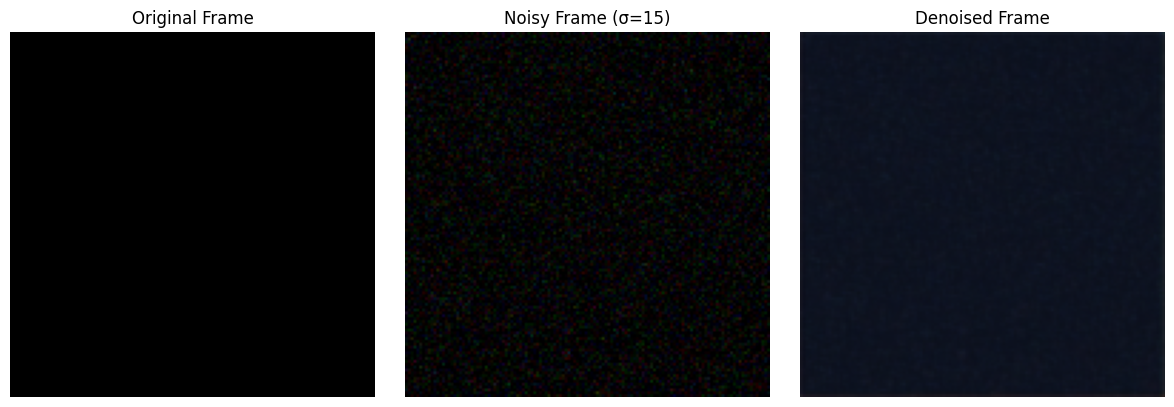

📷 Sample frame comparison saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/sample_frame_comparison.jpg


In [44]:
# Display sample frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_tensor = transform(frame).to(device)
    noisy_frame = add_gaussian_noise(frame_tensor, sigma=15)
    with torch.no_grad():
        denoised_tensor = model(torch.tensor(noisy_frame, dtype=torch.float32).unsqueeze(0).to(device)).squeeze(0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(frame_tensor.cpu().numpy().transpose(1, 2, 0))
    plt.title('Original Frame')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_frame.transpose(1, 2, 0))
    plt.title('Noisy Frame (σ=15)')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_tensor.cpu().numpy().transpose(1, 2, 0))
    plt.title('Denoised Frame')
    plt.axis('off')
    plt.tight_layout()
    sample_path = os.path.join(output_dir, 'sample_frame_comparison.jpg')
    plt.savefig(sample_path)
    plt.show()
    print(f"📷 Sample frame comparison saved to {sample_path}")

cap.release()

In [48]:
# Function to re-encode video to H.264 (Baseline profile for compatibility)
def reencode_to_h264(input_path, output_path):
    cmd = [
        'ffmpeg', '-y', '-i', input_path, '-c:v', 'libx264',
        '-profile:v', 'baseline', '-level', '3.0', '-preset', 'fast',
        '-crf', '23', '-c:a', 'aac', '-b:a', '128k', output_path
    ]
    try:
        subprocess.run(cmd, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print(f"FFmpeg error: {e.stderr.decode()}")
        raise

# Play the re-encoded videos
from IPython.display import Video, display, HTML
print("🎬 Playing output videos:")
video_files = ['original_video.mp4', 'noisy_video_sigma15.mp4', 'denoised_video.mp4']  # Ensure order
html_content = '<div style="display: flex; justify-content: space-around; align-items: center;">'
for video_file in video_files:
    video_path = os.path.join(local_dir, video_file)
    # Re-encode with Baseline profile
    reencode_to_h264(os.path.join(output_dir, video_file), video_path)
    label = video_file.replace('.mp4', '').replace('_', ' ').title()
    html_content += f'<div style="text-align: center; margin: 0 10px;"><div style="font-weight: bold;">{label}</div>{Video(video_path, embed=True, width=400, height=400, html_attributes="controls")._repr_html_()}</div>'
html_content += '</div>'
display(HTML(html_content))

🎬 Playing output videos:
